# Inferential statistics II - Bootstrapping

## Introduction

In the previous frequentist mini-projects, you did frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th-Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold for the particular case you're working on, and what you want to do has a known theoretical distribution (for example the mean of a sampling distribution that we looked at in the previous mini-project.)

In this mini-project, you'll use the same medical charge data you used in the frequentist inference mini-project, but this time you'll make inferences about the population using bootstrapping (ie. simulating repeated re-runs of an experiment.) If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

While these exercises do not strictly depend on these concepts, we encourage you to complete the previous mini-projects before starting this one so that you can approach this assignment with a good understanding of frequentist concepts like:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete mini-project, it's important that you first complete the bootstrap resources listed in this subunit, as they contain valuable information about how to calculate bootstrap replicates of summary statistics. Having an basic understanding of what confidence intervals and p-values are will also be helpful (we touch on them in this mini-project, but please speak to your mentor or conduct individual research if you'd like to learn more.) 

In [2]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind_from_stats
from scipy.stats import t

## Medical charge data set

In [3]:
med_charges = pd.read_csv('data/insurance2.csv')

In [4]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you'll now use bootstrap inference to verify your calculations and check that you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__

In [5]:
np.random.seed(47)
N_rep = 10000
def bootstrap_replicate(data, func):
    bootstrap = np.random.choice(data, len(data))
    return func(bootstrap)

def draw_bs_replicates(data, func, size=1):
    bs_reps = np.empty(size)
    for i in range(size):
        bs_reps[i] = bootstrap_replicate(data, func)
    return bs_reps

bs_sample = draw_bs_replicates(med_charges['charges'], np.mean, N_rep)
conf_int = np.percentile(bs_sample, [5])
conf_int

array([12724.4679217])

If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember, in the previous mini-projects, we saw that there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap approach!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__ The null hypothesis is that there are no discernible differences between the charges with insurance vs those without insurance. The alternative hypothesis is that the those with insurance are charged differently than those without insurance. Since the p-value obtained is 0.0, we can reject the null hypothesis and that there is sufficient evidence to tell that these two groups are different.

In [6]:
has_insurance = med_charges[med_charges.insuranceclaim == 1]
no_insurance = med_charges[med_charges.insuranceclaim == 0]


In [7]:
bs_has_ins = draw_bs_replicates(has_insurance['charges'], np.mean, size=10000)
has_conf_ins= np.percentile(bs_has_ins, [2.5, 97.5])
has_conf_ins

array([15449.46517024, 17410.39806068])

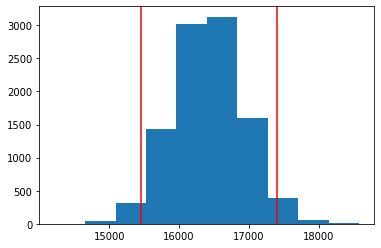

In [8]:
plt.hist(bs_has_ins)
plt.axvline(x=np.percentile(bs_has_ins, 2.5), color ='red')
plt.axvline(x=np.percentile(bs_has_ins, 97.5), color ='red')

In [9]:
bs_no_ins = draw_bs_replicates(no_insurance['charges'], np.mean, size=10000)
no_conf_ins = np.percentile(bs_no_ins, [2.5, 97.5])
no_conf_ins

array([8288.03344735, 9366.56304342])

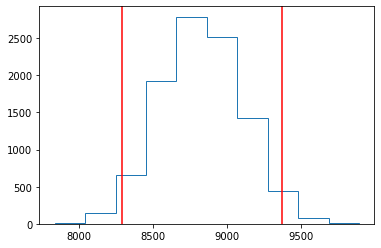

In [10]:
plt.hist(bs_no_ins, histtype='step')
plt.axvline(x=np.percentile(bs_no_ins, 2.5), color ='red')
plt.axvline(x=np.percentile(bs_no_ins, 97.5), color ='red')


In [11]:
ttest_ind_from_stats(mean1=np.mean(bs_has_ins), std1= np.std(bs_has_ins), nobs1=len(bs_has_ins), 
                     mean2=np.mean(bs_no_ins), std2=np.std(bs_no_ins), nobs2=len(bs_no_ins))

Ttest_indResult(statistic=1326.6193915252688, pvalue=0.0)

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type I error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this, this time using the bootstrap approach.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__ Since in this instance, we are assuming that the previous null hypothesis is true, the null hypothesis in this case is that those with insurance and without insurance are charged differently and the alternative hypothesis is that they are charged the same.

In [12]:
bs_concat = np.concatenate([bs_has_ins, bs_no_ins])
concat_mean = np.mean(bs_concat)
shift_ins = bs_has_ins - np.mean(bs_has_ins) + concat_mean
shift_no = bs_no_ins - np.mean(bs_no_ins) + concat_mean

In [13]:
bs_shift_ins = draw_bs_replicates(shift_ins, np.mean, 10000)
bs_shift_no = draw_bs_replicates(shift_no, np.mean, 10000)

In [43]:
bs_diff_of_means = bs_shift_ins - bs_shift_no
#bs_diff_of_means
diff_of_means = np.mean(bs_has_ins) -np.mean(bs_no_ins)
diff_of_means

7600.225428377524

In [46]:
p = np.sum(bs_diff_of_means >= diff_of_means) / len(bs_diff_of_means)
p

0.0

__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A:__ I plotted more than one line since the observed differences in the 95th percentile have two endpoints. I did not plot the actual differences in the mean, since it would make the histogram unreadable.

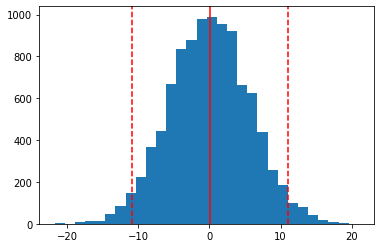

In [60]:
plt.hist(bs_diff_of_means,bins=30)
plt.axvline(x=np.mean(bs_diff_of_means), color='red')
plt.axvline(x=np.percentile(bs_diff_of_means, [2.5]), color='red', linestyle='--')
plt.axvline(x=np.percentile(bs_diff_of_means, [97.5]), color='red',linestyle='--')

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__ The p-values were more or less the same in both assignments. Yes.

__Q:__ Consider the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__ I would use the two-tailed t-test in this assignment, since the values are normally distributed.

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real-world consequence of rejecting the null hypothesis?

__A:__ I would perform a two-sided test as above. My null hypothesis would be that the new algorithm had no effect on click-through rate, and the alternate hypotheses would be that the new algorithm performed either worse or better than the current algorithm. The real world consequence of rejecting the null hypothesis would be to use the new algorithm (in the scenario it performed better).

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have:
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.